In [242]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [243]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [244]:
device

device(type='cuda')

In [245]:
ticker = 'MSFT'
df = yf.download(ticker, '2020-01-01')

/tmp/ipython-input-3186683050.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [246]:
df

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2020-01-02,152.791168,152.895807,150.612792,151.040856,22622100
2020-01-03,150.888611,152.153786,150.355908,150.603245,21116200
2020-01-06,151.278625,151.345221,148.881450,149.423674,20813700
2020-01-07,149.899292,151.887418,149.651970,151.554487,21634100
2020-01-08,152.286911,152.962311,150.251219,151.183448,27746500
...,...,...,...,...,...
2025-08-25,504.260010,508.190002,504.119995,506.630005,21638600
2025-08-26,502.040009,504.980011,498.510010,504.359985,30835700


<Axes: xlabel='Date'>

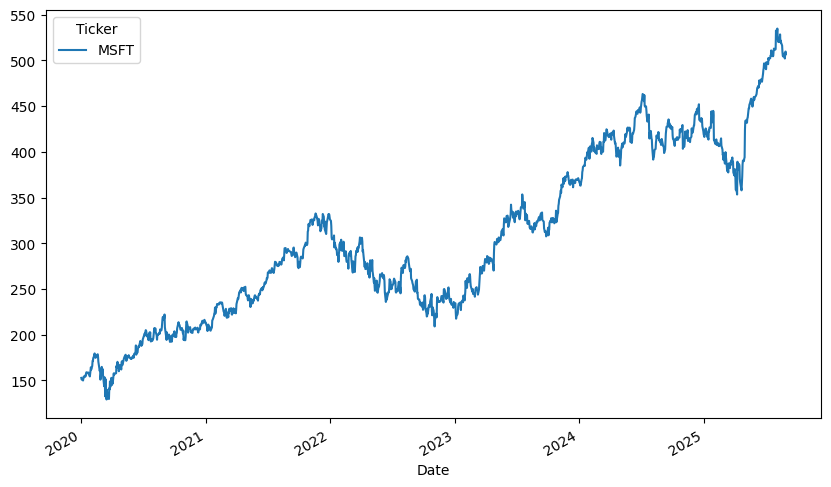

In [247]:
df.Close.plot(figsize=(10,6))

In [248]:
scaler = StandardScaler()
#scaled_data = scaler.fit_transform(df.Close.values.reshape(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'])

In [249]:
df.Close

Ticker,MSFT
Date,
2020-01-02,-1.641303
2020-01-03,-1.661737
2020-01-06,-1.657548
2020-01-07,-1.672363
2020-01-08,-1.646719
...,...
2025-08-25,2.133642
2025-08-26,2.109798
2025-08-27,2.160278


In [250]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
  data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [251]:
data

array([[[-1.64130304],
        [-1.66173743],
        [-1.65754848],
        ...,
        [-1.39793481],
        [-1.39517659],
        [-1.40539346]],

       [[-1.66173743],
        [-1.65754848],
        [-1.67236319],
        ...,
        [-1.39517659],
        [-1.40539346],
        [-1.38863735]],

       [[-1.65754848],
        [-1.67236319],
        [-1.64671901],
        ...,
        [-1.40539346],
        [-1.38863735],
        [-1.36942965]],

       ...,

       [[ 2.13933611],
        [ 2.20453125],
        [ 2.18683836],
        ...,
        [ 2.16554128],
        [ 2.13364203],
        [ 2.10979814]],

       [[ 2.20453125],
        [ 2.18683836],
        [ 2.18694554],
        ...,
        [ 2.13364203],
        [ 2.10979814],
        [ 2.16027822]],

       [[ 2.18683836],
        [ 2.18694554],
        [ 2.1355831 ],
        ...,
        [ 2.10979814],
        [ 2.16027822],
        [ 2.19142588]]])

In [252]:
train_size = int (0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1,:]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1,:]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1,:]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1,:]).type(torch.Tensor).to(device)

In [253]:
class PredictionModel(nn.Module):

  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(PredictionModel,self).__init__()

    self.num_layers = num_layers
    self.hidden_dim = hidden_dim

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)

    out,(hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :])

    return out

In [254]:
model = PredictionModel(input_dim = 1, hidden_dim = 32, num_layers = 2, output_dim = 1).to(device)

In [255]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [256]:
num_epochs = 200

for i in range(num_epochs):
  y_train_pred = model(X_train)

  loss = criterion(y_train_pred, y_train)

  if i % 25 == 0:
    print(i, loss)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

0 tensor(0.6169, device='cuda:0', grad_fn=<MseLossBackward0>)
25 tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)
50 tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward0>)
75 tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward0>)
100 tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward0>)
125 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward0>)
150 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)
175 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)


In [257]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [258]:
train_rmse = np.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
test_rmse = np.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))

In [259]:
train_rmse

np.float64(5.278725285834692)

In [260]:
test_rmse

np.float64(11.380257198598368)

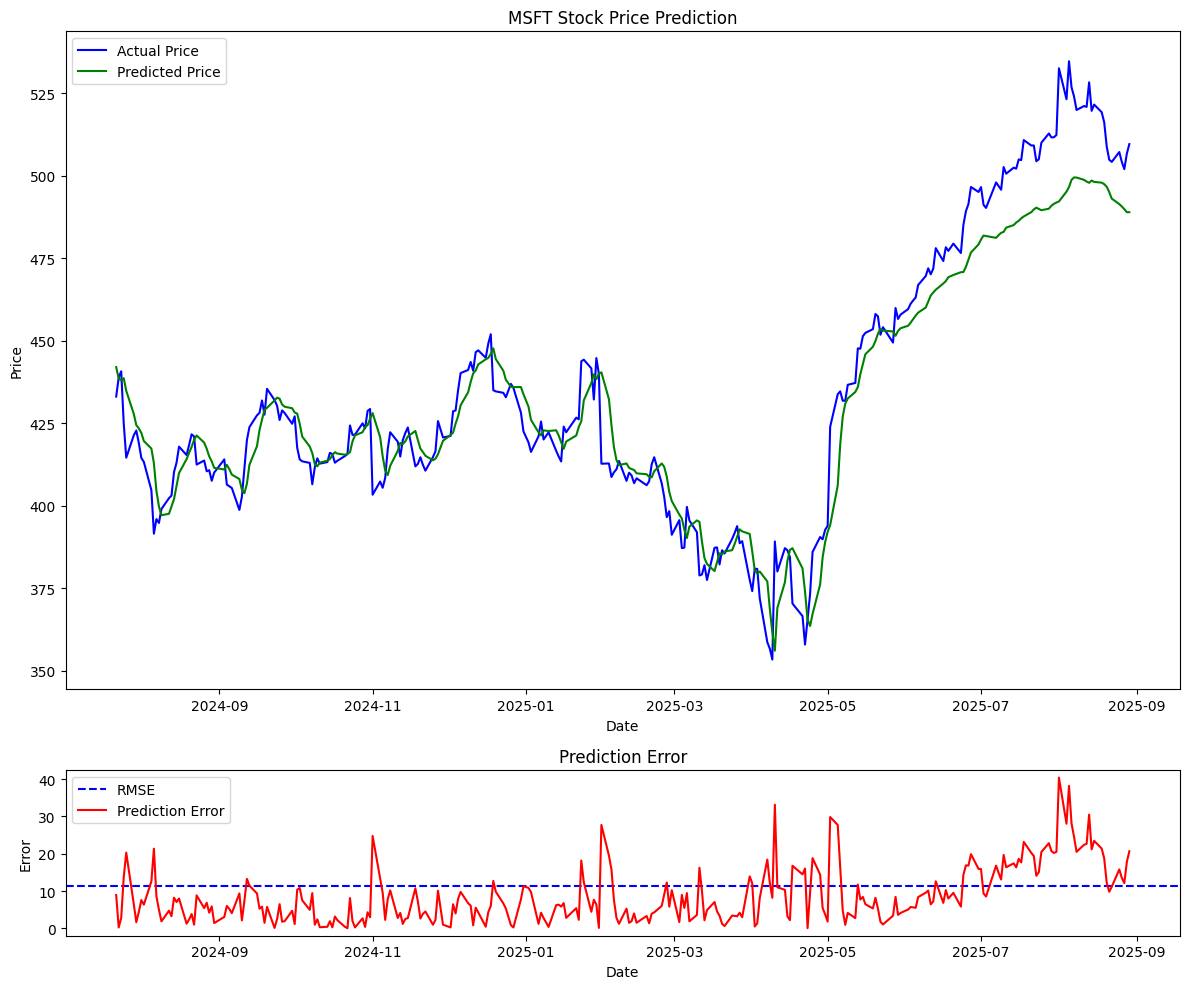

In [261]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")


ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'blue', linestyle = '--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title("Prediction Error")
plt.xlabel("Date")
plt.ylabel("Error")
plt.tight_layout()
plt.show()